In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
print("Time Series Analysis - Exchange Rate Forecasting")
print("Loading USD/AUD Exchange Rate Data...")

Time Series Analysis - Exchange Rate Forecasting
Loading USD/AUD Exchange Rate Data...


In [4]:
df_raw = pd.read_csv('/content/sample_data/exchange_rate.csv',
                     skiprows=1,
                     header=None,
                     names=['date_str', 'time_rate'])

In [5]:

df_raw['date'] = pd.to_datetime(df_raw['date_str'], format='%d-%m-%Y %H:%M')

In [6]:

df_raw['exrate'] = pd.to_numeric(df_raw['time_rate'], errors='coerce')

In [7]:
#Clean data
df = df_raw[['date', 'exrate']].dropna().sort_values('date')
df.set_index('date', inplace=True)

In [8]:
print(f"Cleaned data: {len(df)} observations ({df.index.min()} to {df.index.max()})")

Cleaned data: 7588 observations (1990-01-01 00:00:00 to 2010-10-10 00:00:00)


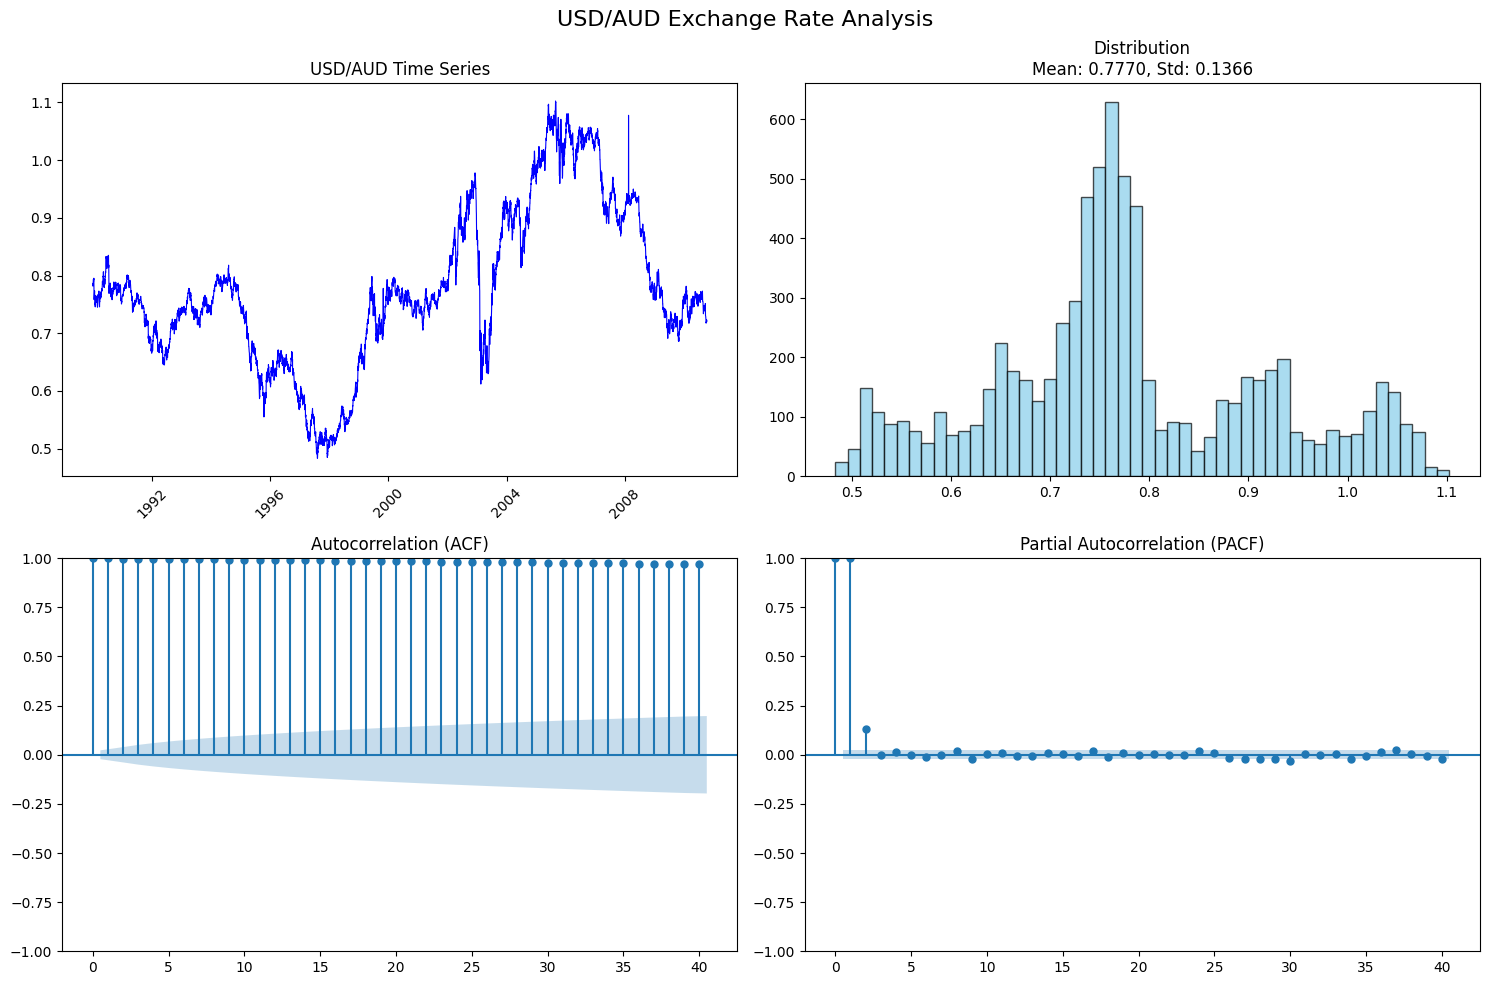


ADF Stationarity Test:
ADF Statistic: -1.664994
p-value: 0.449233
✗ Series is non-stationary (Differencing required)

Fitting ARIMA(1,1,1) model...


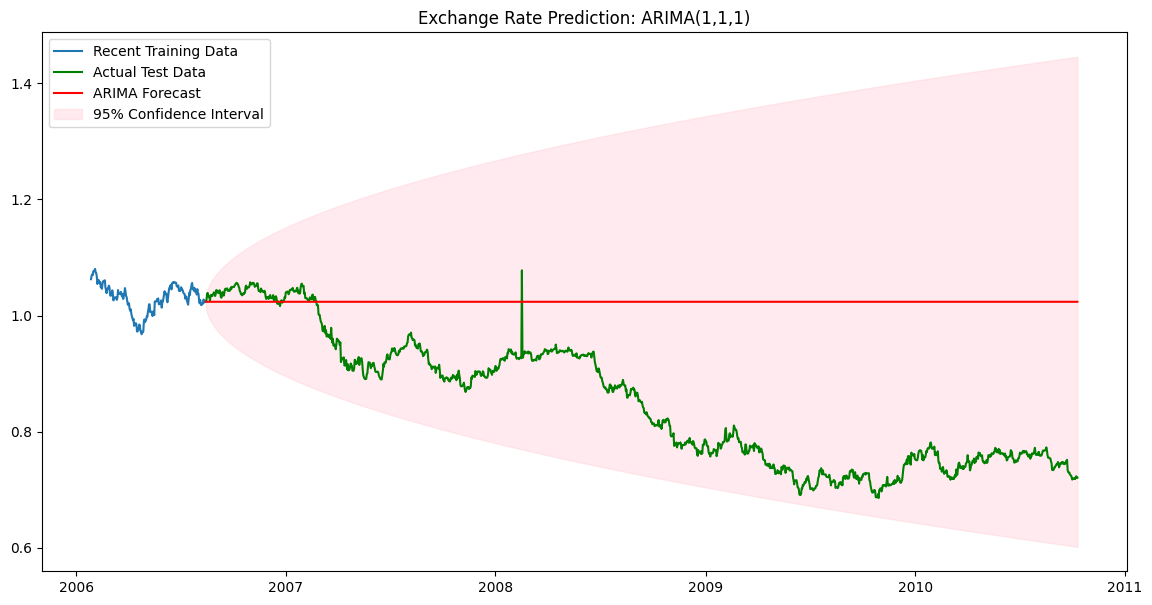

ARIMA(1,1,1) RMSE: 0.205437

✓ Analysis complete!


In [9]:
if len(df) == 0:
    print("ERROR: No valid data found after parsing!")
else:
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('USD/AUD Exchange Rate Analysis', fontsize=16)

    # 1. Time series plot
    axes[0, 0].plot(df.index, df['exrate'], linewidth=0.8, color='blue')
    axes[0, 0].set_title('USD/AUD Time Series')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Distribution
    axes[0, 1].hist(df['exrate'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 1].set_title(f'Distribution\nMean: {df["exrate"].mean():.4f}, Std: {df["exrate"].std():.4f}')

    # 3. ACF
    plot_acf(df['exrate'], lags=40, ax=axes[1, 0])
    axes[1, 0].set_title('Autocorrelation (ACF)')

    # 4. PACF
    plot_pacf(df['exrate'], lags=40, ax=axes[1, 1])
    axes[1, 1].set_title('Partial Autocorrelation (PACF)')

    plt.tight_layout()
    plt.show()

    # Stationarity Test
    adf_result = adfuller(df['exrate'])
    print(f"\nADF Stationarity Test:")
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("✓ Series is stationary" if adf_result[1] < 0.05 else "✗ Series is non-stationary (Differencing required)")

    # ARIMA Forecasting
    if len(df) > 100:
        # Split data
        train_size = int(len(df) * 0.8)
        train, test = df.iloc[:train_size], df.iloc[train_size:]

        print("\nFitting ARIMA(1,1,1) model...")
        # (1,1,1) assumes 1 Lag, 1 Difference to make it stationary,and 1 Moving Average term
        model = ARIMA(train['exrate'], order=(1,1,1))
        fitted = model.fit()

        # Forecast
        forecast_steps = len(test)
        forecast_res = fitted.get_forecast(steps=forecast_steps)
        forecast = forecast_res.predicted_mean
        forecast_ci = forecast_res.conf_int()

        #Plotforecast
        plt.figure(figsize=(14, 7))
        plt.plot(train.index[-200:], train['exrate'].tail(200), label='Recent Training Data')
        plt.plot(test.index, test['exrate'], label='Actual Test Data', color='green')
        plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
        plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                         color='pink', alpha=0.3, label='95% Confidence Interval')
        plt.title('Exchange Rate Prediction: ARIMA(1,1,1)')
        plt.legend()
        plt.show()

        #Evaluation
        rmse = np.sqrt(np.mean((forecast.values - test['exrate'].values)**2))
        print(f"ARIMA(1,1,1) RMSE: {rmse:.6f}")

    print("\n✓ Analysis complete!")